In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline 

In [2]:
!unzip -q archive.zip

replace annotations.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
os.listdir(path='/content/')

['.config',
 'archive',
 'annotations.csv',
 'images',
 'Trafic_sign.hdf5',
 'archive.zip',
 '.ipynb_checkpoints',
 'sample_data']

In [4]:
# importing cv2 
import cv2 as cv

In [5]:
import pandas as pd
df=pd.read_csv('annotations.csv')
df.head()

,file_name,width,height,x1,y1,x2,y2,category
0,000_0001.png,134,128,19,7,120,117,0
1,000_0002.png,165,151,23,12,149,138,0
2,000_0003.png,128,122,22,14,116,105,0
3,000_0010.png,80,73,14,8,67,63,0
4,000_0011.png,186,174,36,15,155,157,0


In [6]:
df['category'] = df['category'].astype('str')

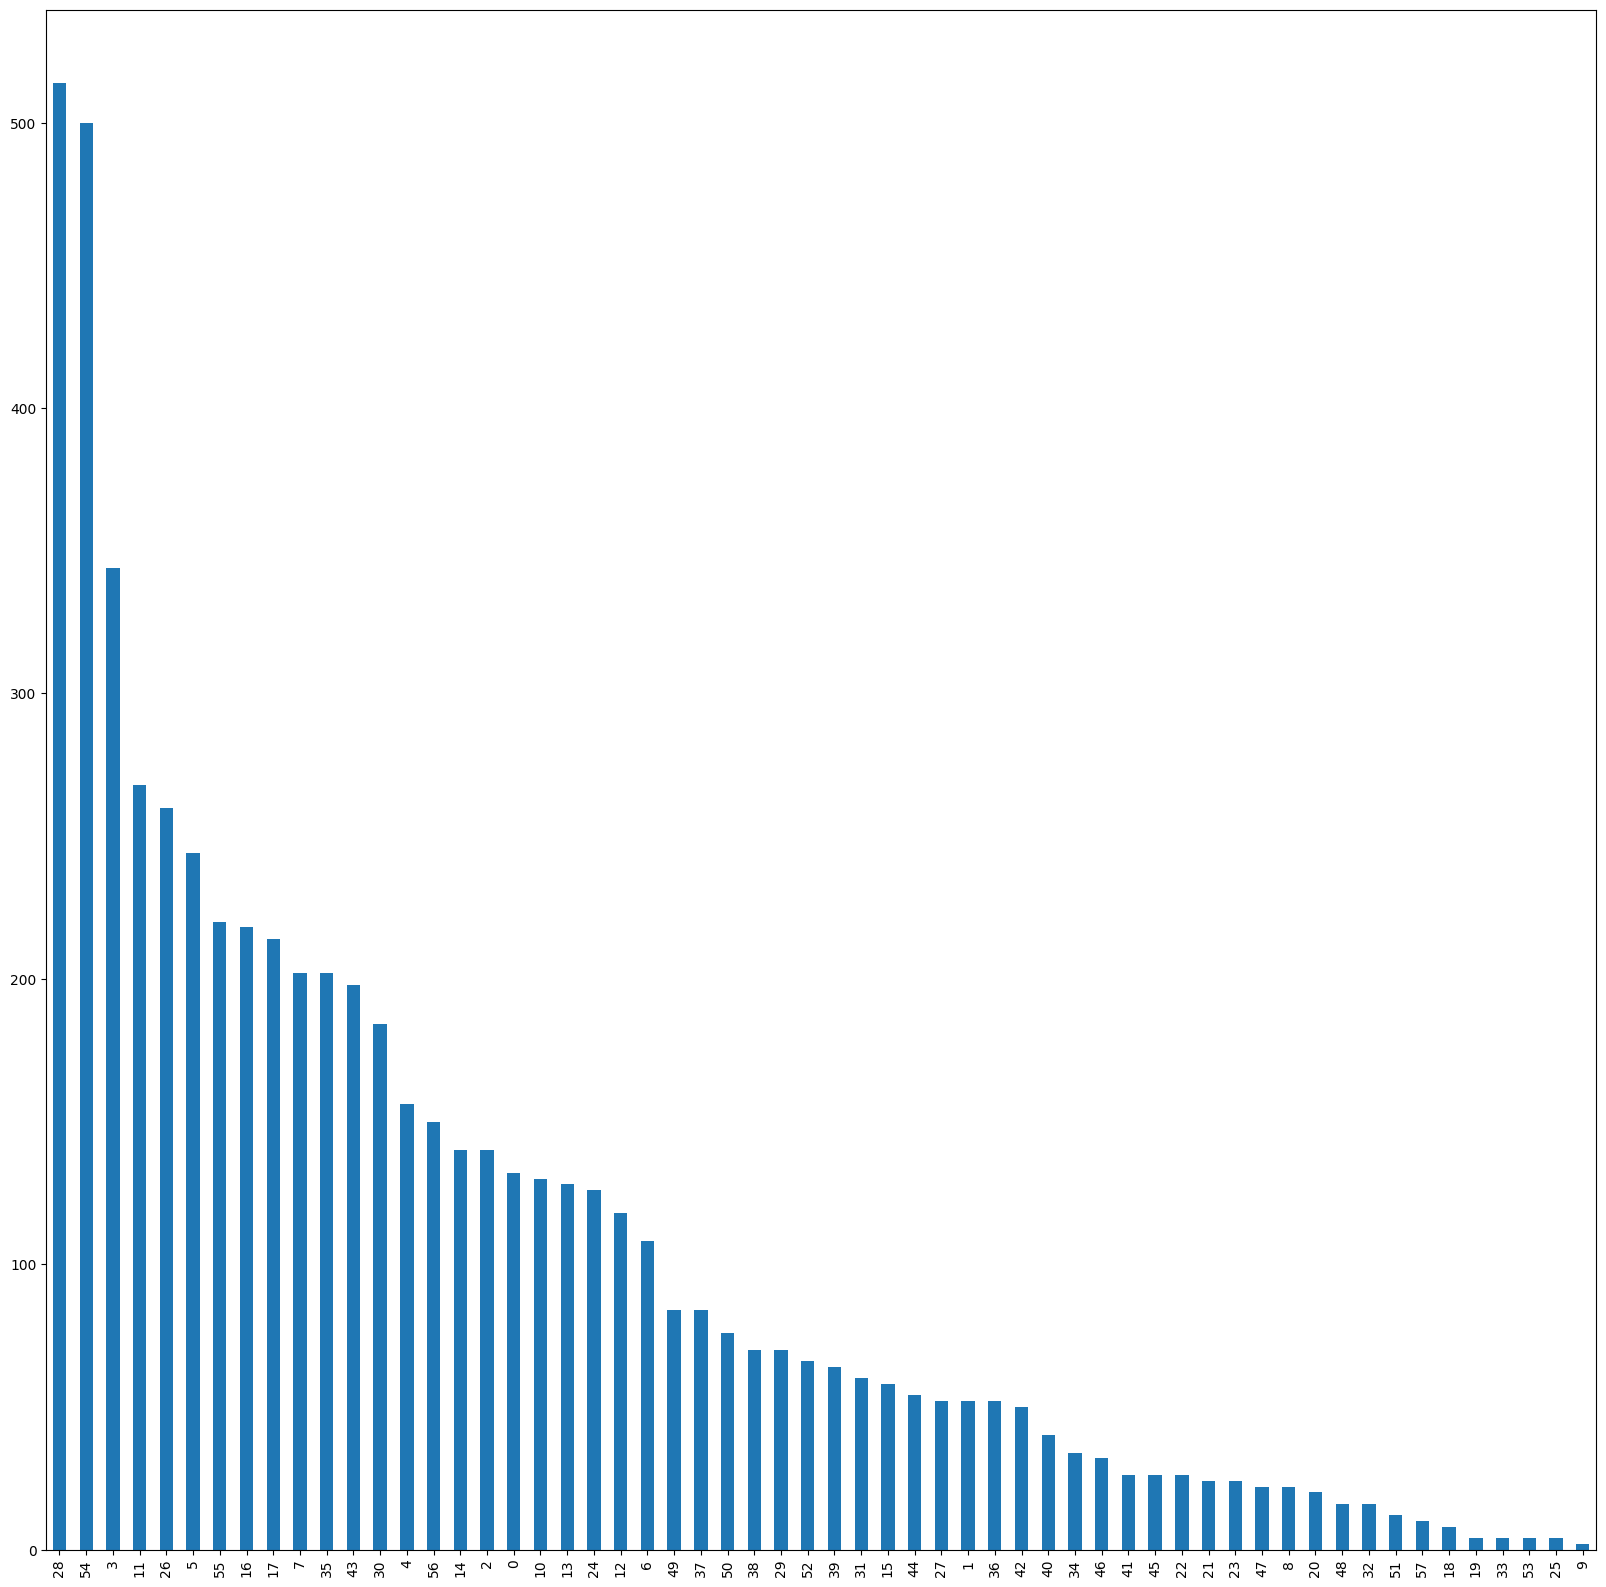

In [7]:
plt.figure(figsize=(20,20))
df['category'].value_counts().plot(kind='bar')
plt.show()

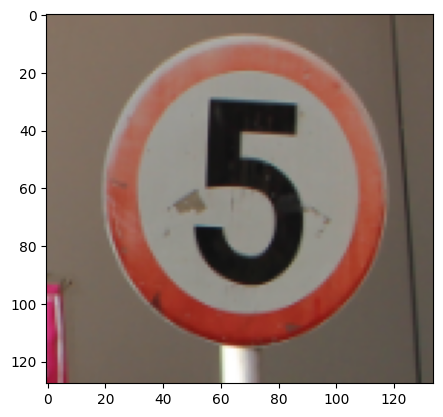

In [8]:
path='images/000_0001.png'
img=plt.imread(path)
plt.imshow(img)

In [9]:
path='/content'

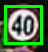

category: 3


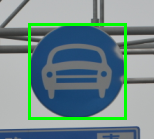

category: 28


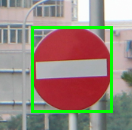

category: 55


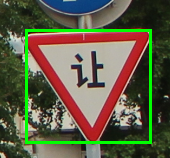

category: 56


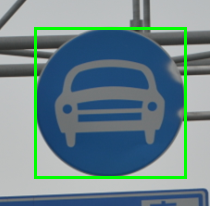

category: 28


In [10]:
import IPython.display as display
from PIL import Image
from PIL.ImageDraw import Draw

for index, row in df.sample(frac=1)[:5].iterrows():
    image = Image.open(os.path.join(path, 'images', row.file_name))
    draw = Draw(image)
    draw.rectangle([row.x1, row.y1, row.x2, row.y2], outline='#00FF00', width=3)
    display.display(image)
    print('category:', row.category)


In [11]:
img.shape

(128, 134, 3)

In [12]:
from keras.applications.mobilenet_v2 import  preprocess_input
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            
            preprocessing_function=preprocess_input,
            validation_split=0.1,
            featurewise_center=False,
            featurewise_std_normalization=False,
            rotation_range=15,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
            
            )

In [13]:
        # Train generator
train_generator = datagen.flow_from_dataframe(
            dataframe=df,
            directory="images",
            x_col="file_name",
            y_col="category",
            has_ext=False,
            subset="training",
            batch_size=16,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=(224,244))
        print('Train generator created')

Found 5548 validated image filenames belonging to 58 classes.
Train generator created


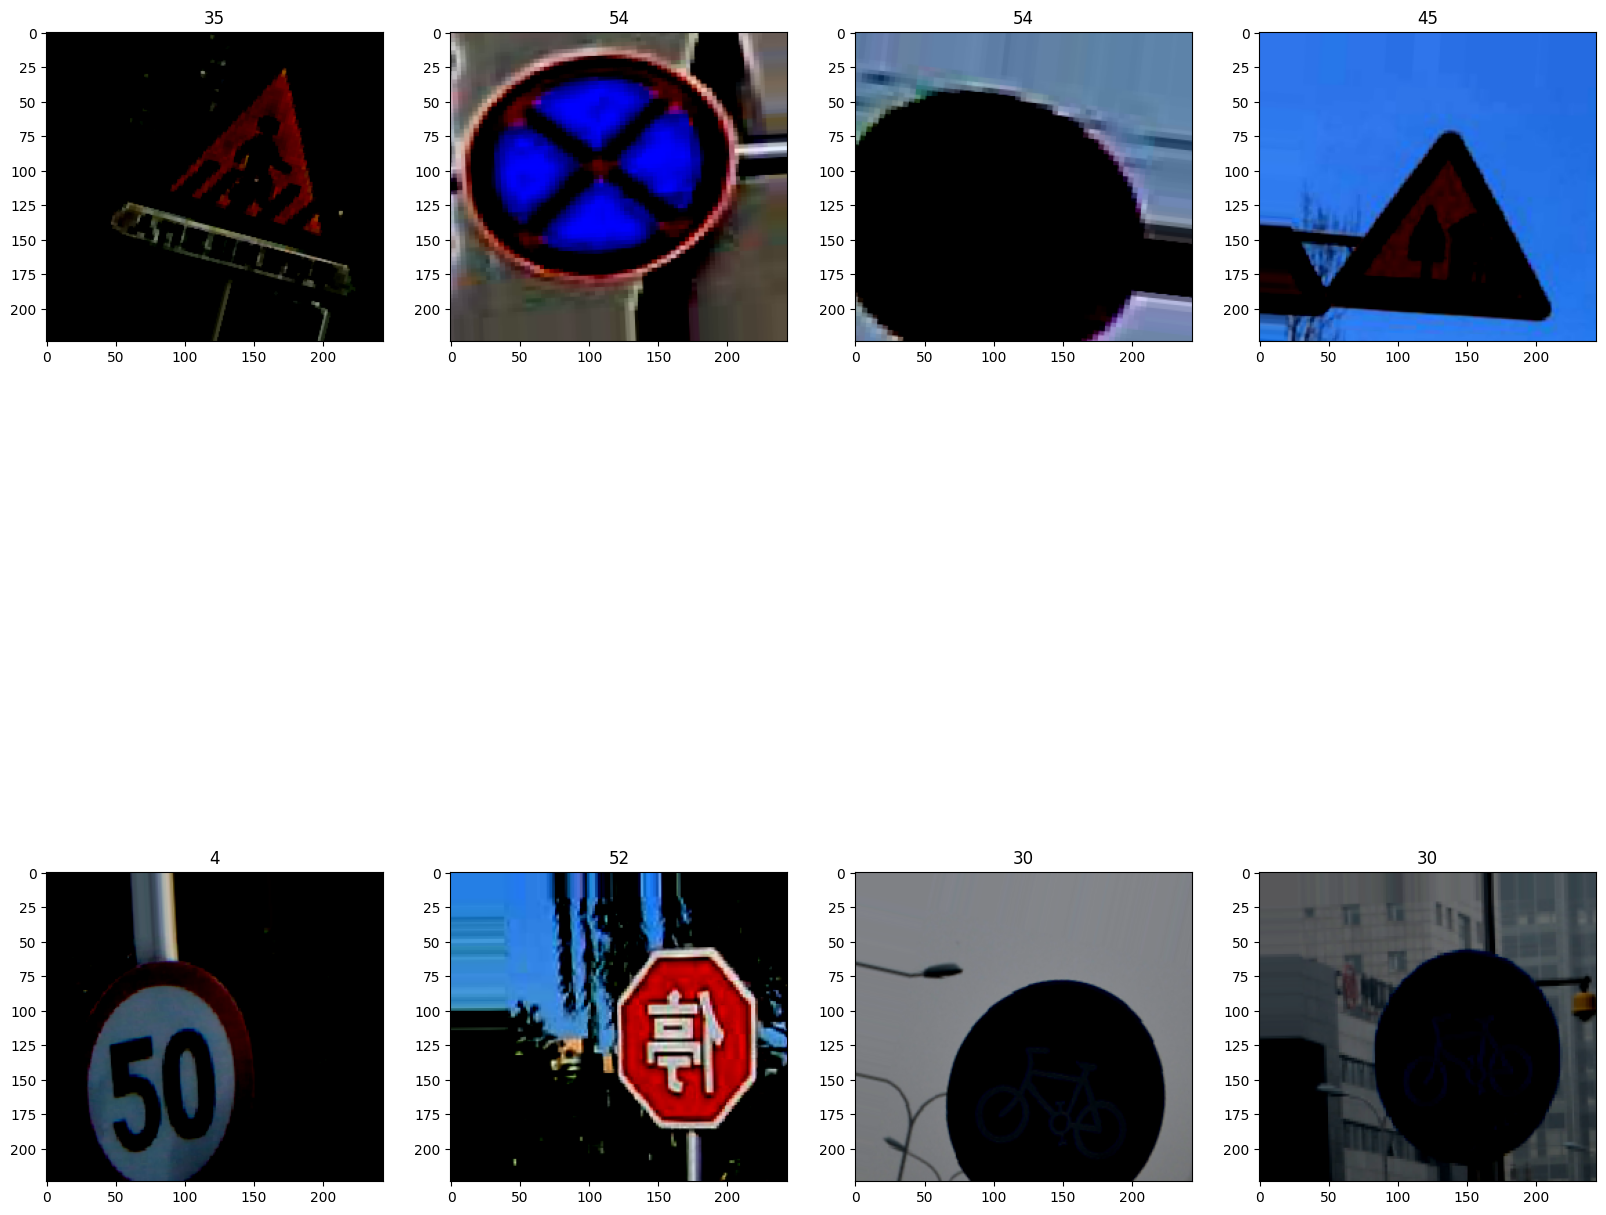

In [14]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,8):
        plt.subplot(2,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [15]:
from keras.applications.mobilenet_v2 import  preprocess_input
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            
            preprocessing_function=preprocess_input,
            validation_split=0.1,
            
            )
val_generator = datagen.flow_from_dataframe(
            dataframe=df,
            directory='images',
            x_col="file_name",
            y_col="category",
            has_ext=False,
            subset="validation",
            batch_size=16,
            seed=42,
            shuffle=False,
            class_mode="categorical",
            target_size=(224,224)) 

Found 616 validated image filenames belonging to 58 classes.


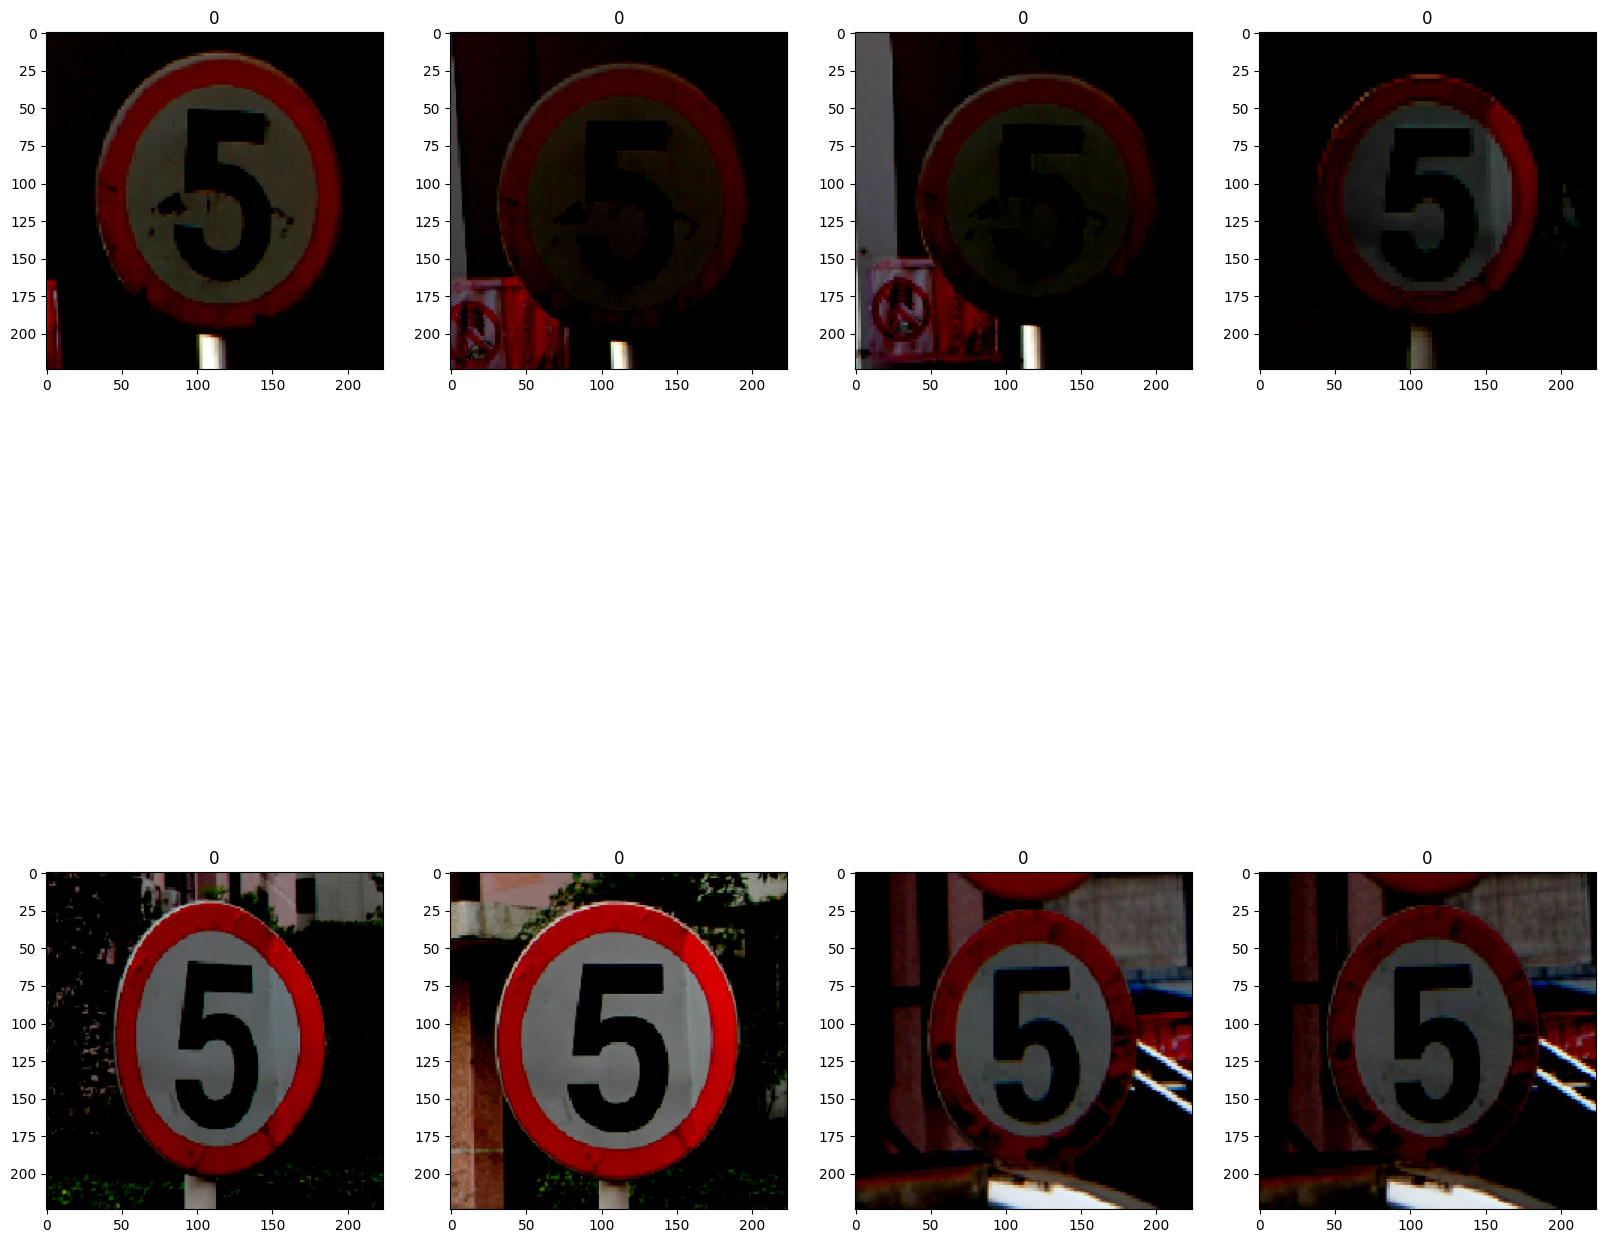

In [16]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in val_generator:
    # create a grid of 3x3 images
    for i in range(0,8):
        plt.subplot(2,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [17]:
len(classes)

58

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

In [19]:
optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('Trafic_sign.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]
from keras.applications.mobilenet_v2 import MobileNetV2
mb=MobileNetV2(include_top=False,input_shape=(224,224,3),weights='imagenet')
mb.trainable=False

In [20]:
model = Sequential()
model.add(mb)
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 1024 , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 58 , activation = 'softmax'))

In [21]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=["accuracy"])
history=model.fit(train_generator,validation_data=val_generator,epochs=100,batch_size=16,
                  steps_per_epoch=len(train_generator)//16,validation_steps=len(val_generator)//16,
                  callbacks=callback, verbose=1)

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 3.7147 - accuracy: 0.2649
Epoch 1: val_loss improved from inf to 16.30762, saving model to Trafic_sign.hdf5
21/21 [==============================] - 38s 2s/step - loss: 3.7147 - accuracy: 0.2649 - val_loss: 16.3076 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 2.3372 - accuracy: 0.4337
Epoch 2: val_loss improved from 16.30762 to 7.99605, saving model to Trafic_sign.hdf5
21/21 [==============================] - 41s 2s/step - loss: 2.3372 - accuracy: 0.4337 - val_loss: 7.9960 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 1.9480 - accuracy: 0.4821
Epoch 3: val_loss did not improve from 7.99605
21/21 [==============================] - 33s 1s/step - loss: 1.9480 - accuracy: 0.4821 - val_loss: 8.2614 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - ETA: 0s 

In [22]:
loss,acc=model.evaluate(val_generator)

39/39 [==============================] - 22s 556ms/step - loss: 1.0837 - accuracy: 0.9042


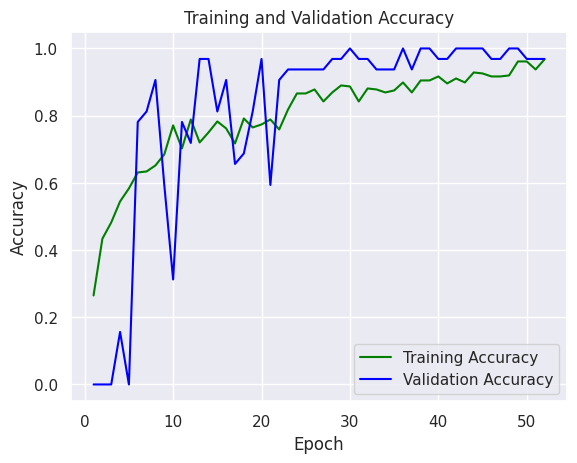

<Figure size 640x480 with 0 Axes>

In [23]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.figure()
plt.show()

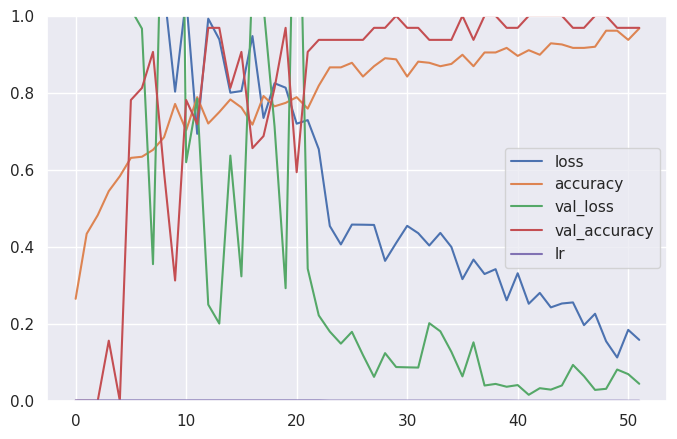

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [25]:
predictions = model.predict(val_generator)

39/39 [==============================] - 23s 556ms/step


In [26]:
from sklearn.metrics import classification_report
print(classification_report(val_generator.classes, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.79      1.00      0.88        15
           2       1.00      0.50      0.67         4
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        30
           5       0.79      1.00      0.88        11
           6       1.00      1.00      1.00        40
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00        16
           9       0.98      1.00      0.99        40
          10       1.00      0.33      0.50         3
          11       0.00      0.00      0.00         2
          12       0.86      0.97      0.91        32
          13       0.86      1.00      0.92         6
          14       1.00      0.25      0.40         4
          15       1.00      0.50      0.67         6
          16       1.00      1.00      1.00         4
          17       1.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

<Axes: >

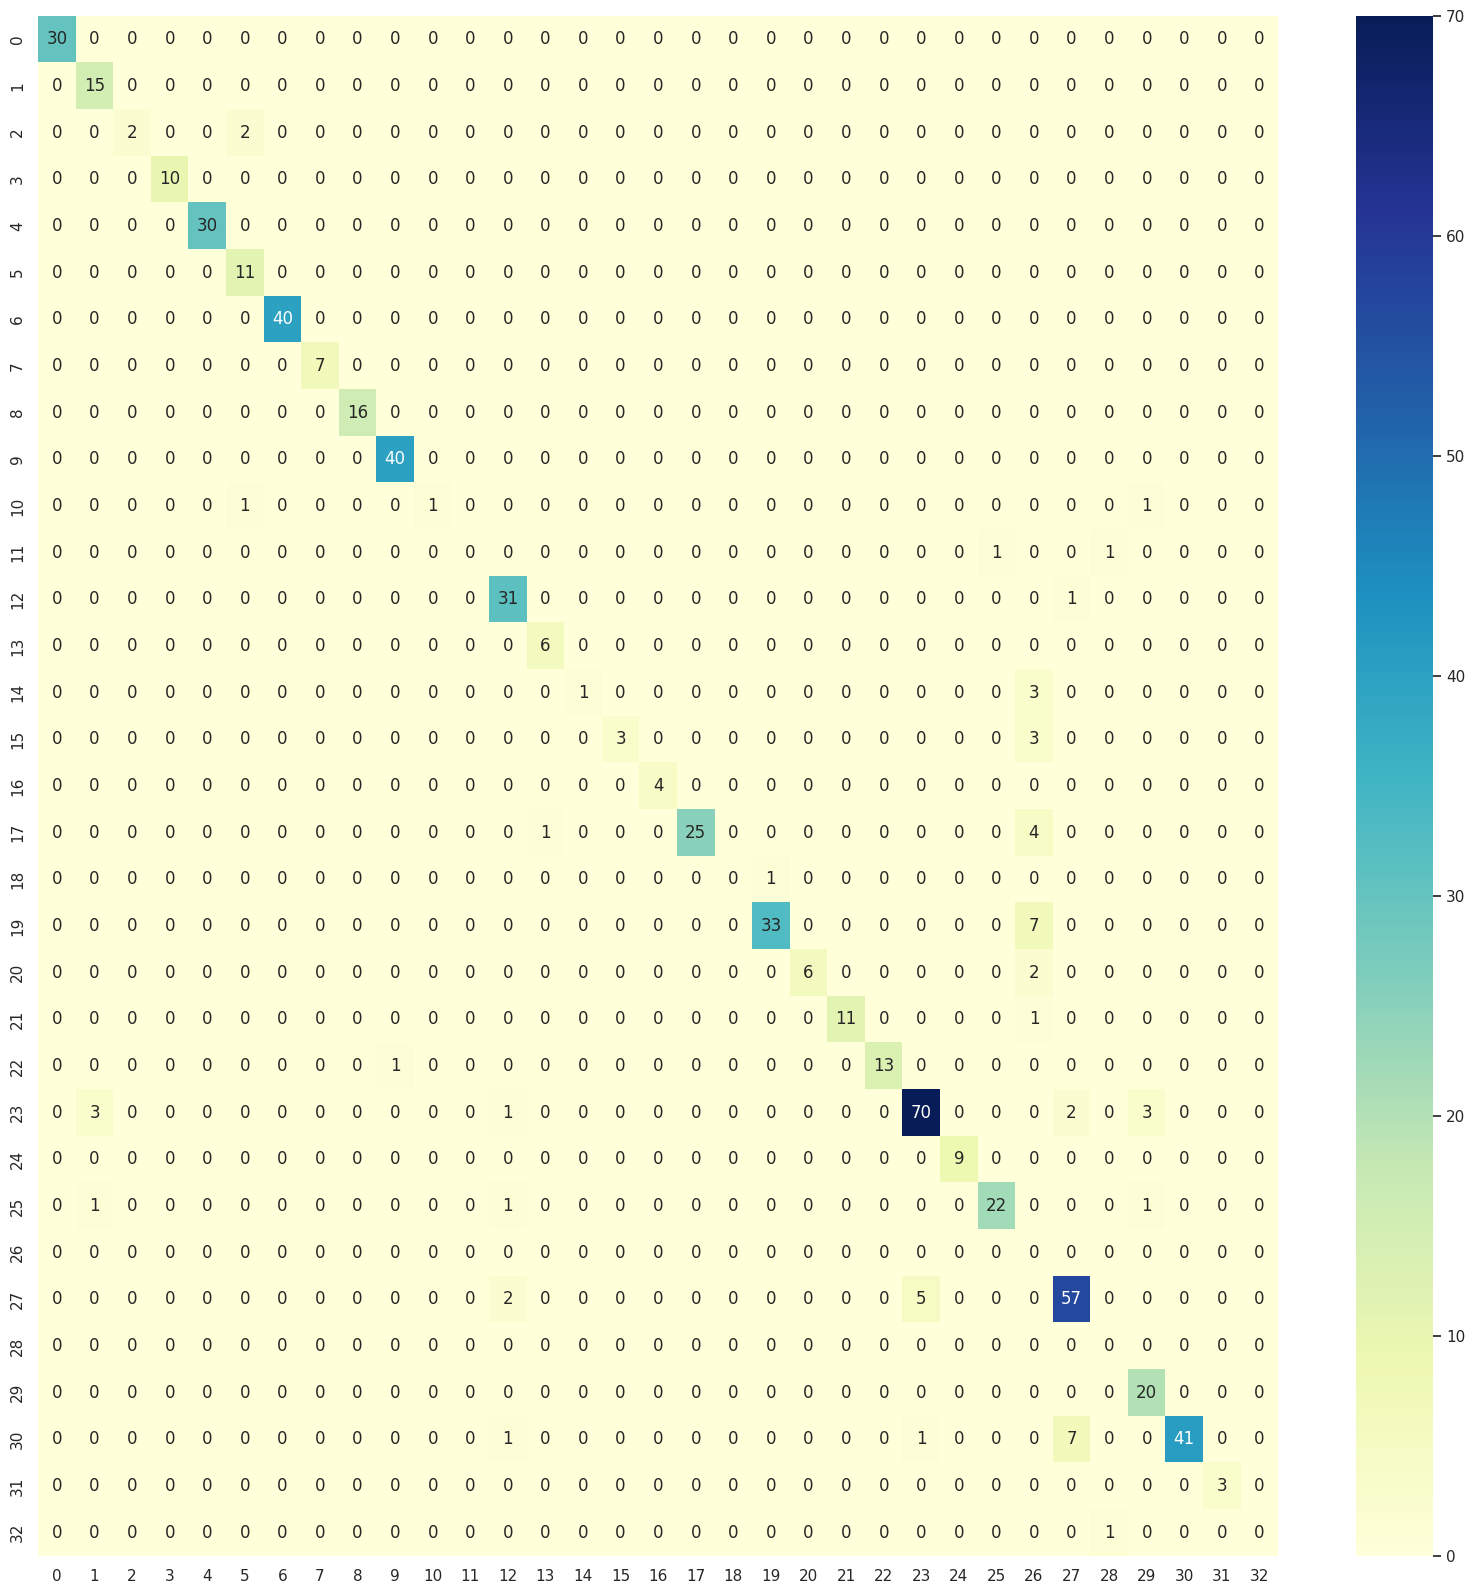

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_generator.classes, predictions.argmax(axis=1))
plt.figure(figsize=(20,20))
sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")